# Week 6 Lab Report


## Introduction

**Background (<font color="red">Intro-Q1</font> - 1 pt)**: In your own words, summarize background and motivation for using scRNA-seq data. 

scRNA-seq allows us to understand the gene expression of different cell types in areas where the expression of genes in cells isn't heterogenous (i.e. there are different cell types with different expression profiles in a target area).

**Summary of your findings (<font color="red">Intro-Q2</font> - 2 pts)**: Provide 3-5 sentences summarizing the datasets you analyzed and the findings of your analyses. For example: describe the clusters you found and the genes that were differentially expressed in each.

We looked at scRNA-seq data from 10x Genomics single cell technology of cells from brain of a mouse embryo. We looked at the differential expression of genes in different cells and created clusters of similar cells (presumably same cell type) using PCA and t-SNE visualizations. We were able to determine the top 3 genes for each cluster that we created, and noticed at least some clusters seemed to differntiate blood and brain cells (Having some clusters express Eomes, a TF found in the brain, and Hbb genes which are found in blood cells).

## Methods

**Dataset description (<font color="red">Methods-Q1</font> - 3 pts)**: Summarize the datasets we are starting with: what type of data are we analyzing? Where did they come from? How many reads are there in each dataset, and what is the read length? How many different libraries were pooled together (you can get this by counting the number of unique index reads, but ignoring index sequences with very few counts since those are likely just due to sequencing errors).

We have data from paired end reads of 2 lanes of an Illumina flowcell. Each lane has the 2 fastq files for each paired end read and then an index file.

Lane 1:

number of reads = 46358484

read length = 28

number of libraries = zcat neuron_1k_v3_S1_L002_I1_001.fastq.gz | awk 'NR % 4 == 2'| sort | uniq -c | awk '{if ($1 > 10) print $1}' | wc -l = 119

#Note that we chose libraries w/ at least 10 copies of each library sequence

Lane 2:

number of reads = 46543747

read length = 28

number of libraries = 116

**Data processing (<font color="red">Methods-Q2</font> - 1 pt)**: Summarize the methods used to perform alignment and gene expression quantification. What cell ranger command was used? Which reference? What were the inputs and outputs? Specify any non-default options. 

We used Cellranger's count command to perform alignment and gene expresison quantification with the mm10 reference transcriptome. The inputs were the fastq files we looked at inthe last step. Our output was a feature matrix (in sparse format) that gives the number of transcripts in each cell (barcode). We also set the parameter "id" to "mouse_brain"

**Data exploration (<font color="red">Methods-Q3</font> - 1 pt)**: Cite the library and version you used to load in the feature barcode matrix.  How many genes and total cells were included in the loaded data?

We used scanpy version 1.7.2 to load in the matrix. We had 1301 cells and 31053 genes

**Calculating distribution (<font color="red">Methods-Q4</font> - 3 pts)**: Describe how the percentage of mitochondrial genes and number of counts are calculated from the matrix to add to the observations for the AnnData object. What were the top 3 barcodes of the cells that had the highest percentage of mitochondrial genes? What were the top 3 barcodes of the cells that had the highest number of counts?

To calculate percent mitochondrial genes, we divide the sum of the expression of mitochondrial genes by the sum of expression of all genes for each cell. We get number of counts by just summing up the expression of all genes.

**Variable genes (<font color="red">Methods-Q5</font> - 3 pts)**: Describe how you filtered cells with too high a percentage of mitochondrial genes and too high total counts. What cutoffs did you choose and why? If you used any other filters describe those here.

I chose 40,000 as a cutoff for maximum number of genes just by eyeballing from the graphs (most cells have count less than 40,000). I chose 0.125 as a cutoff for percent_mito, since just from looking at the graphs it looks like that is the point where the base of the high percent_mito spike is. I also filtered out cells with less than 800 genes, since they seemed to be an outlier on the n_counts vs. n_genes graph

**Finding highly variable genes (<font color="red">Methods-Q6</font> - 3 pts)**: Describe methods and filters you used to find highly variable genes.

I used scanpy's highly_variable_genes method with default parameters except for 'flavor' which I set to 'cell_ranger'

In [31]:
sc.pp.highly_variable_genes(adata_filt, flavor="cell_ranger")

**t-SNE with Scanpy (<font color="red">Methods-Q7</font> - 3 pts)**: Describe the methods you used to run t-SNE using Scanpy.

I used scanpy's tsne method with 7 PCs to create the t-SNE plot, and scanpy's neighbors method with 10 neighbors and louvain to create the clusters.

## Results

**Filtering (<font color="red">Results-Q1</font> - 2 pts)**: Report the number of cells and number of genes you filtered out at each step (i.e. after each cell-level and gene-level filter). 

filtered out 28 cells that have less than 100 genes expressed

filtered out 16383 genes that are detected in less than 5 cells

filtered out 1545 genes that are detected in less than 15 counts

**Highly Expressed Genes (<font color="red">Results-Q2</font> - 3 pts)**: What are the top 6 highest expressed genes? What do you notice in common with them? (you do not need to include the plot in your report).

mt-Atp6

mt-Co3

Malat1

mt-Co2

mt-Cytb

mt-Co1

Many of these are mitochondrial genes (start with prefix "mt-")

**Filtering - violin plots (<font color="red">Results-Q3</font> - 4 pts)**: Make violin plots using Scanpy to visulize the distribution of `n_genes`, `percent_mito`, and `n_counts` across all cells. Describe the distributions of each value and include an image of the plots.

First block just loads in data and does processing as described in instructions, then second block shows the plots

n_counts has a very dense distribution at lower values, but has some small amount of outliers\

percent_mito is also dense at lower values (~0.1), but there's a somewhat steady distribution of values up to 1

n_genes has a normal looking distribution at around (2000-6000), with a small subset of cells that have lower values.

In [2]:
import scanpy as sc
# Load in the data
adata = sc.read_10x_mtx("/datasets/cs185-sp21-A00-public/week6/filtered_feature_bc_matrix/",var_names='gene_symbols', cache=True)
sc.pp.filter_cells(adata, min_genes=101) #28 filtered
sc.pp.filter_genes(adata, min_cells=5) #16383 filtered
sc.pp.filter_genes(adata, min_counts=15) #13125 filtered
import numpy as np
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
## add the total counts per cell as observations-annotation to adata
sc.pp.filter_cells(adata, min_genes=0)
adata.obs['n_counts'] = adata.X.sum(axis=1).A1


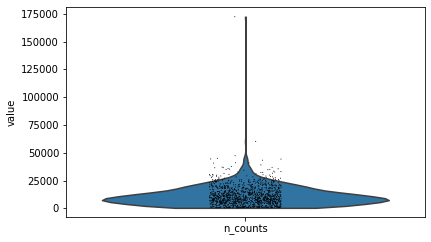

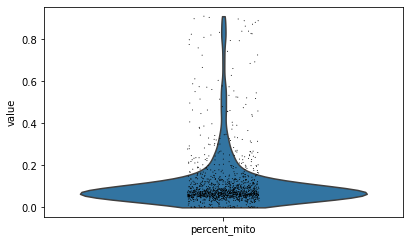

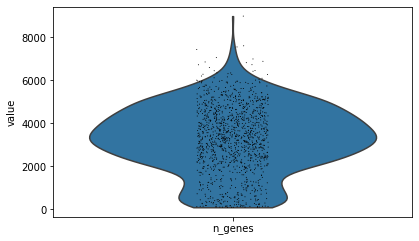

In [7]:
sc.pl.violin(adata, ["n_counts", ])
sc.pl.violin(adata, ["percent_mito"])
sc.pl.violin(adata, ["n_genes"])

**Filtering - Scatter plots (<font color="red">Results-Q4</font> - 4 pts)**: Make scatter plots of all pairs of these variables (`n_counts` vs. `percent_mito`, `n_counts` vs. `n_genes`, and `n_genes` vs. `percent_mito`). You can use either Scanpy or matplotlib to do this. Include both scatter plots in your report. Describe and interpret the shape of these plots. For instance: are the cells with the most mitochondrial genes the same cells with many counts? Are there any outlier points? What could those mean?

It seems that cells with a high percent_mito also have much lower counts and fewer genes. If we see higher mitochondrial gene expression when cells are dying, then it's possible that RNA just doesn't get transcribed as much due to some sort of signalling that happens at apoptosis.

There seems to be 2 noticable outlier points where they have low percent_mito but high n_counts and n_genes. These could represent some sort of duplicate barcode (or something of the same effect)

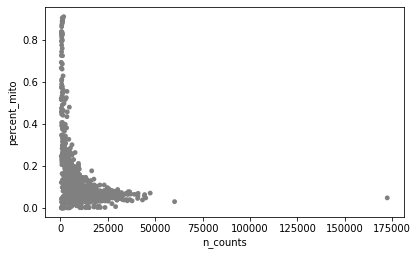

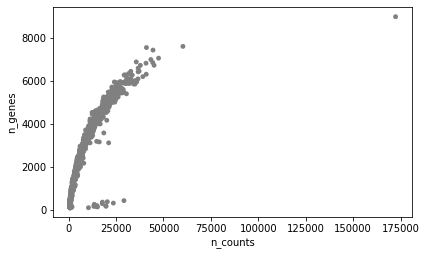

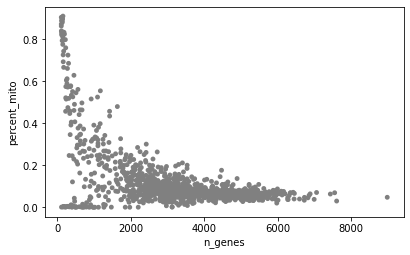

In [10]:
sc.pl.scatter(adata, "n_counts", "percent_mito")
sc.pl.scatter(adata, "n_counts", "n_genes")
sc.pl.scatter(adata, "n_genes", "percent_mito")

**Filtering results (<font color="red">Results-Q5</font> - 8 pts)**: Make violin plots of the distributions of each variable (`n_genes`, `percent_mito`, and `n_counts`) now after filtering. Make scatter plots again of what you did for <font color="red">**Results-Q4**</font> after filtering. How do the plots look? How many cells are you left with after filtering?

We have 1090 cells left after filtering. The violin plots show distributions that have much shorter outlier regions (i.e. shorter at top and bottom)

The scatter plots show that there isn't much association with percent_mito and either n_genes or n_counts after filtering, and there's still a positive correlation between n_genes and n_counts

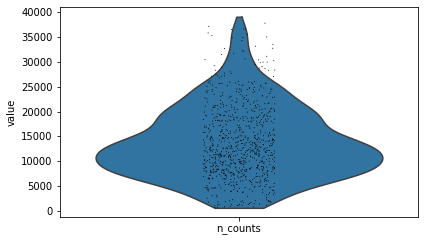

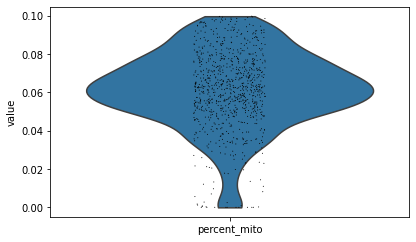

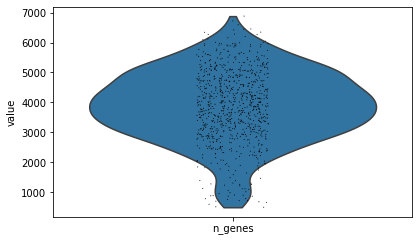

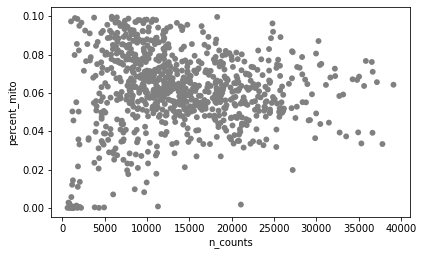

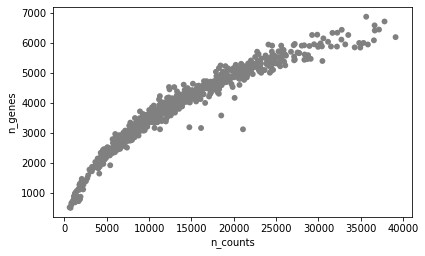

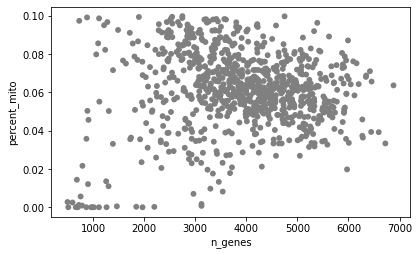

In [28]:
adata_filt = adata[(adata.obs["n_genes"]>500) & (adata.obs["n_counts"]<40000) & (adata.obs["percent_mito"]<0.1), :]
sc.pl.violin(adata_filt, ["n_counts", ])
sc.pl.violin(adata_filt, ["percent_mito"])
sc.pl.violin(adata_filt, ["n_genes"])
sc.pl.scatter(adata_filt, "n_counts", "percent_mito")
sc.pl.scatter(adata_filt, "n_counts", "n_genes")
sc.pl.scatter(adata_filt, "n_genes", "percent_mito")

**Filtering results (<font color="red">Results-Q6</font> - 3 pts)**: Check the highest expressed genes of the cells after filtering. What are the top 6 highest expressed genes? How do they compare to those found before filtering? Pay attention to both the set of genes at the top, but also the values on the x-axis that indicate the percent of total counts.

You might still see some outlier cells with a tiny number of genes expressed, and one top expressed gene (Hbb-bs) that accounts for a huge percentage of the total counts. What do you think is causing those two artifacts?

Top 6 are:

Malat1

mt-Atp6

mt-Co3

Tubala

Tmsb4x

mt-Co3

We have fewer mitochondrial genes this time around. I filtered out that artifact that accounted for a huge percentage of total counts, but I think that could just have to do with some cells being in a certain part of the cell cycle where that gene is very highly expressed.

/home/n4wilson/.local/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


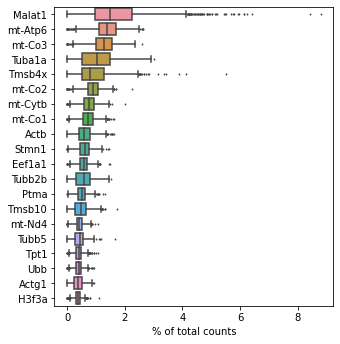

In [24]:
sc.pl.highest_expr_genes(adata_filt, n_top=20)

**Variable genes (<font color="red">Results-Q7</font> - 4 pts)**: How many genes are in your highly variable set? What are the top 5 most variable genes? Why do we only care about the genes that differ between the cells?

We have 4407 genes in highly variable set, and the top 5 are:

Hba-a2

Hba-a1

Cldn5

Ccl4

Rgs5

We care about the most variable genes since they'll allow us to differentiate cell types versus genes that are expressed similarly between all cells

In [46]:
adata_var = adata_filt[:, adata_filt.var["highly_variable"]]
adata_var_sorted = adata_var.var["dispersions_norm"].sort_values()
adata_var_sorted

Speg         0.500086
Coro2a       0.500501
Ly96         0.500501
Cebpz        0.500782
Ints10       0.501214
             ...     
Rgs5       719.822449
Ccl4       736.879578
Cldn5      791.883606
Hba-a1    3127.489746
Hba-a2    3580.401855
Name: dispersions_norm, Length: 4407, dtype: float32

**PCA and TSNE plots - CellRanger (<font color="red">Results-Q8</font> - 5 pts)**: Include your PCA and t-SNE plots based on CellRanger output. Describe how the plots are similar or different. How do the cells cluster? How many clusters do you see?

The clusters are easier to see on TSNE, since a few different cluster types seem to converge at the top on PCA. On TSNE, we can see that there are no overlapping cell types (at least generally). I can see from the colors that there are 6 clusters, but if there were no colors, I'd probably pick out 4 clusters for PCA and 5-6 for TSNE.

Text(0, 0.5, 'TSNE-2')

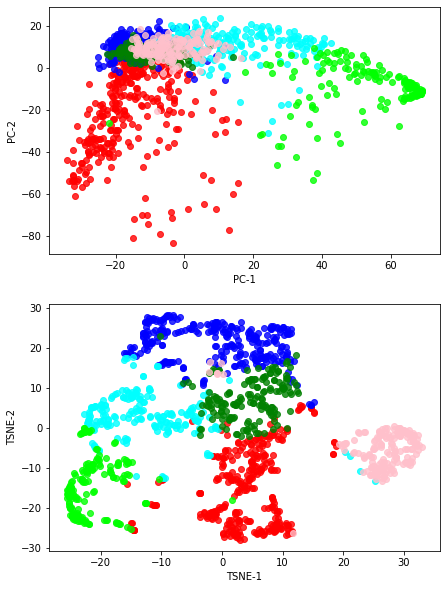

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

pca = pd.read_csv("/datasets/cs185-sp21-A00-public/week6/analysis/pca/10_components/projection.csv")
tsne = pd.read_csv("/datasets/cs185-sp21-A00-public/week6/analysis/tsne/2_components/projection.csv")
clusters = pd.read_csv("/datasets/cs185-sp21-A00-public/week6/analysis/clustering/graphclust/clusters.csv") 

#6 clusters
colors = ["red","blue","cyan","green","pink","lime"]
fig = plt.figure()
fig.set_size_inches((7, 10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#this is a really bootleg solution
for i in range(1,7):
    barcodes = clusters.loc[clusters["Cluster"]==i]["Barcode"].tolist()
    points_pca = pca.loc[pca["Barcode"].isin(barcodes)]
    points_tsne = tsne.loc[tsne["Barcode"].isin(barcodes)]
    ax.scatter(points_pca["PC-1"], points_pca["PC-2"], color=colors[i-1], alpha=0.8)
    ax2.scatter(points_tsne["TSNE-1"], points_tsne["TSNE-2"], color=colors[i-1], alpha=0.8)
ax.set_xlabel("PC-1")
ax.set_ylabel("PC-2")
ax2.set_xlabel("TSNE-1")
ax2.set_ylabel("TSNE-2")

**t-SNE using Scanpy (<font color="red">Results-Q9</font> - 8 pts)**: Include your t-SNE image based on Scanpy. How do the cells cluster? How many clusters do you see? Is your plot similar or different than the one output by Cell Ranger?

Also try to color your tsne plot based on the clusters identified by Cell Ranger (from the clustesr.csv file). Do cells from the same clusters from 10X cluster together on your t-sne plot?

We do see that the regions from Cell Ranger form the same clusters (they include more since there are fewer clusters [i.e. Cell Ranger clusters encompass multiple of my cluster])

In [84]:
sc.tl.tsne(adata_var, n_pcs = 7)
sc.pp.neighbors(adata_var, n_neighbors=10)
sc.tl.louvain(adata_var)

         Falling back to preprocessing with `sc.pp.pca` and default params.


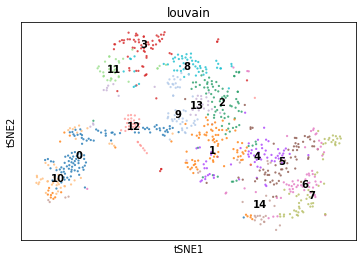

In [86]:
sc.pl.tsne(adata_var, color=['louvain'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

Text(0, 0.5, 'TSNE-2')

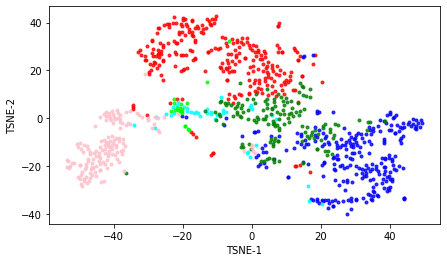

In [129]:
louvain = adata_var.obs['louvain']
data = pd.DataFrame(adata_var.obsm['X_tsne'], index=louvain.index, columns=["TSNE-1","TSNE-2"])
data["Barcode"] = data.index
merged = data.merge(clusters, how='left', on="Barcode")
fig = plt.figure()
fig.set_size_inches((7, 4))
ax = fig.add_subplot(111)
#this is a really bootleg solution
for i in range(1,7):
    valid = merged.loc[merged["Cluster"]==i]
    ax.scatter(valid["TSNE-1"], valid["TSNE-2"], color=colors[i-1], alpha=0.8, marker='.')
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")

**Top genes/cluster - Scanpy (<font color="red">Results-Q10</font> - 6 pts)**:  What are the top 3 genes for each cluster reported by Scanpy? Do the genes you find differ for each cluster? What might be a possible explanation for the differences in the variable genes found in each cluster? Tip: Think of the different types of cells and their function in the brain.

Cluster 0: Nrnx3, Gad2, Dlx2

Cluster 1: Mir124-2hg, Robo2, Cux1

Cluster 2: Rnd2, Sema3c, Scrt2

Cluster 3: Mfge2, Qk, Ddahn2

Cluster 4: Igsf3, Mn1, Sh3bp5

Cluster 5: Idh1, Actl6b, Opcml

Cluster 6: Cnr1, Camk2b, Hewc1

Cluster 7: Nell2, Grin2b, Rac3

Cluster 8: Eomes, Neurog2, gsf8

Cluster 9: Eomes, Fam53b, Neurog2

Cluster 10: Nrxn3, Gad2, Gad1

Cluster 11: H2afx, Birc5, Ccna2

Cluster 12: Trem2, Fcer1g, gsf8

Cluster 13: Rnd2, Cited2, Unc5d

Cluster 14: Nrxn1, Arpp21, Tenm2

These genes are generally different for each cluster, although Clusters 8 and 9 are similar, and other clusters do share some genes. This is because there are different cell types in the brain that (by definition of being different cell types) express different genes. For example, there are neuron cells and there are also blood cells, which express very different genes because they have very different functions.

**Top genes/cluster - CellRanger (<font color="red">Results-Q11</font> - 6 pts)**:  What are the top 3 genes for each cluster reported by Cellranger? Are they the same ones as the ones you found using Scanpy? If they differ, provide a possible explanation why this might be the case.

Cluster 1: Eomes, Pbk, Cdk1

Cluster 2: Sox2, Eomes, Arx

Cluster 3: Arpp21, Gria2, Pcdh9

Cluster 4: Pdzrn3, Hbb-bs, Phgdh

Cluster 5: Lhx6, Maf, Erbb4

Cluster 6: Hba-a1, Hba-a2, Hbb-bs

Some genes are similar, such as Eomes, but largely the top genes are different. This is likely since Scanpy broke up the clusters into more clusters, so more specific genes for each cell type were picked.

## Discussion

**<font color="red">Discussion-Q1</font> - 3 pts**: Describe the differences between 3'-end based scRNA-seq technologies like 10X Genomics vs. full transcript methods like SMART-seq. What are advantages/disadvantages of each, and for which applications would each one be preferred?

3'-end scRNA-seq technologies obviously only sequence the 3' end of RNA fragments, whereas full transcript will sequence the entire RNA fragment. One advantage of 3' end sequencing is that it's much higher throughput, meaning that more cells can be sequenced using 3' end technologies. Full transcript methods are better though if you want to capture splicing/isoform information or catch mutations near beginning of a transcript. If we're trying to differentiate cell types, it's sufficient to use 3' end based sequencing, but if we did a project where we cared about how mRNA gets spliced, then we'd want the information that we gain from doing full transcript sequencing.

**<font color="red">Discussion-Q2</font> - 3 pts**: How might we validate that our clustering methods, such as t-SNE, are giving us reasonable results? What if we had ground truth data for several example cell types?

If we had data that already told us which genes were highly expressed in each cell type (or at least certain genes that probably belong to one specific cell, such as saying gene X is highly expressed in blood cells specifically), then we could check that gene X was in fact a differentially expressed gene. 

## References

**References (<font color="red">References-Q1</font> - 1 pt)**: Provide at least 2 works that you cite in your report. For example, you will likely reference Cellranger, Scanpy, and 10x genomics where the data is taken from.

Citation for paper that scanpy came from (linked on scanpy docs):

Wolf, F., Angerer, P. & Theis, F. SCANPY: large-scale single-cell gene expression data analysis. Genome Biol 19, 15 (2018). https://doi.org/10.1186/s13059-017-1382-0

Cellranger (format given on 10x Genomics website):

10x Genomics Cell Ranger 3.0.2